In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def min_value(x):
    min_x = np.zeros(len(x)-1)
    for ii, x_i in enumerate(x[:-1]):
        min_x[ii] = abs(x[ii+1] - x[ii])
    mx = np.min(min_x)
    return mx
# uniform dx selection

def interpolation(x,y):
    mx = min_value(x) 
    dx = mx/2
    x_final = np.array([])
    y_final = np.array([])
    for ii, x_i in enumerate(x[:-1]):
        x_new = np.arange(x[ii],x[ii+1],dx) # x에서 mx가 최소가 되는 값의 / 100 을해서  dx 가 일정하게 맞춤.
        if ii >= len(x) - 2 :
            y_new = np.linspace(y[ii],y[ii+1],len(x_new))
        else :
            y_new = np.linspace(y[ii],y[ii+1],len(x_new),endpoint=False)
        x_final = np.append(x_final,x_new)
        y_final = np.append(y_final,y_new)
    return x_final, y_final
# Interpolation

def find_y(x,r_new,em_new): 
    dx = 0.0005
    y = np.where((r_new>= x-dx) & (r_new<= x+dx))[0]
    y_new=em_new[y].mean()
    return y_new

In [3]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning

# from scipy.integrate import simps
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # tt = nden_CIV / n_H
    # print(tt.mean())

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/CIV_cloudy.txt', sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
    return print("make data file!")

# def SB(z,radius_kpc, emissivity,dr):
#     r_min, r_max = radius_kpc.min(), radius_kpc.max()  
#     Project_R  = np.linspace(0,100,300) * kpc
#     N = len(Project_R )
#     surface_brightness = np.zeros(N)
#     Lumin = np.zeros(N)
#     T_Lumin = np.zeros(N)
#     dR_pro = Project_R[1] -Project_R[0] 
#     for ii, bb in enumerate(Project_R):
#         array_R = np.where(radius_kpc >= bb)[0]
#         r_surface_brightness = 0
#         for dR in (array_R):
#             r_surface_brightness += emissivity[dR] * dr[dR] 
#         surface_brightness[ii] = 2*r_surface_brightness / (1+z)**4 
#         Lumin[ii] = 4*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

#     return Project_R/ kpc, surface_brightness ,Lumin



def SB(z, radius_kpc, emissivity, dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()  
    Project_R = np.linspace(0, 100, 300) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)
    T_Lumin = np.zeros(N)
    dR_pro = Project_R[1] - Project_R[0]

    # 적분 함수 정의 (j(r) * dr 부분을 적분)
    def integrand(r):
        
        if r < 1*kpc :
            yy = 0
        else : yy = np.interp(r, radius_kpc, emissivity)

        return np.interp(r, radius_kpc, emissivity)  # 선형 보간을 이용하여 j(r) 값 추정

    for ii, bb in enumerate(Project_R):
        # 적분 수행: R ~ r_max 범위에서 j(r) dr 적분
        r_surface_brightness, _ = quad(integrand, bb, r_max)
        
        surface_brightness[ii] = 2 * r_surface_brightness / (1 + z) ** 4

        Lumin[ii] = 4 * np.pi * bb * surface_brightness[ii] * dR_pro * (1 + z) ** 4

    return Project_R / kpc, surface_brightness, Lumin


def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

warng pyCloudy config: pyCloudy works better with matplotlib Triangulation


In [4]:
#Ubuntu_path
path_or = r'/home/jin/T_Cloudy/Origin/CIV_Lumin_42' # Ryd =1 or 4 # no OTS , LT 
path_n = r'/home/jin/T_Cloudy/OTS_y_LT_n/CIV_Lumin_42' # OTS , no LT
path_y = r'/home/jin/T_Cloudy/OTS_y_LT_y/CIV_Lumin_42' # OTS , yes LT
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

#Ubuntu_path_RT

RT_path_or =r'/home/jin/T_Cloudy/Origin/data_RT_ryd_4/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_n =r'/home/jin/T_Cloudy/OTS_y_LT_n/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_y =r'/home/jin/T_Cloudy/OTS_y_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'

RT_test = r' /home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'

In [5]:
cloudy_model = ['or','n','y','LT'] # or - original (no LT, no Diffuse OTS) , n - no LT (on OTS), y - on LT , OTS, LT- no OTS (on LT)
atom_N = 'CIV'
def make_parameter(path,RT_path,atom,cloudy_index):
    z_red_Shift = 0
    globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
    globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
    globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
    globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)]) # , globals()['rt_radius_kpc_{}'.format(cloudy_index)]
    return print("make parameters of {}".format(cloudy_index))

for ii ,cloudy_index in enumerate (cloudy_model) :
    make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

make parameters of or
make parameters of n
make parameters of y
make parameters of LT


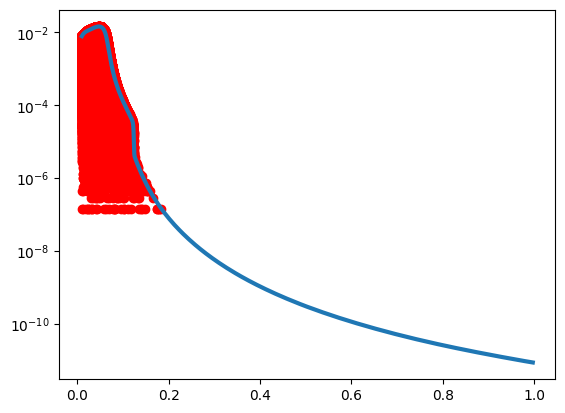

In [6]:
Name = ['x', 'y', 'z', 'radius_accept', 'radius_rand']
file = pd.read_csv('/home/jin/T_Cloudy/CLOUDY_SB/data_cloudy/HeII_photon_data.txt', sep='\s+',  names=Name)
x,y,z,radius_accept, radius_rand = file['x'].to_numpy(), file['y'].to_numpy(), file['z'].to_numpy(),file['radius_accept'].to_numpy(), file['radius_rand'].to_numpy() 


naem = ['radius','emiss','den']
file_c = pd.read_csv('/home/jin/T_Cloudy/HeII_cloudy.txt',sep='\t', names=naem)
# file_den = pd.read_csv('/home/jin/CIV_Photoionization/CIV_number_density.txt',sep='\t',header=0)

# radius,emiss, den = interpolation(file['Radius_kpc'].to_numpy(), file['Emissivity'].to_numpy())
# radius_d,num_den= interpolation(file_den['Radius_kpc'].to_numpy(), file_den['number_density'].to_numpy())

radius_max = 25

radius , emis , den = file_c['radius'].to_numpy() , file_c['emiss'].to_numpy() , file_c['den'].to_numpy()

# ii = np.where(radius<=radius_max )[0]
# plt.plot(radius[ii],emiss[ii])
# radius_civ, emiss_civ,num_den_civ = radius[ii],emiss[ii], num_den[ii]
Total_A = np.sum(emis)
density = emis/Total_A
p_max = density.max()

plt.plot(radius_rand/100,radius_accept*p_max,'ro')
plt.plot(radius/100,density,lw=3)
# plt.xlim(0,0.15)
plt.yscale('log')
# plt.hist(radius_rand,density=True)

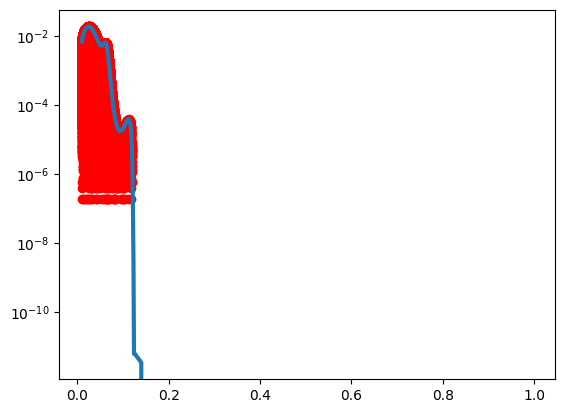

In [8]:
Name = ['x', 'y', 'z', 'radius_accept', 'radius_rand']
file = pd.read_csv('/home/jin/T_Cloudy/CLOUDY_SB/data_cloudy/CIV_photon_data.txt', sep='\s+',  names=Name)
x,y,z,radius_accept, radius_rand = file['x'].to_numpy(), file['y'].to_numpy(), file['z'].to_numpy(),file['radius_accept'].to_numpy(), file['radius_rand'].to_numpy() 


naem = ['radius','emiss','den']
file_c = pd.read_csv('/home/jin/T_Cloudy/CIV_cloudy.txt',sep='\t', names=naem)
# file_den = pd.read_csv('/home/jin/CIV_Photoionization/CIV_number_density.txt',sep='\t',header=0)

# radius,emiss, den = interpolation(file['Radius_kpc'].to_numpy(), file['Emissivity'].to_numpy())
# radius_d,num_den= interpolation(file_den['Radius_kpc'].to_numpy(), file_den['number_density'].to_numpy())

radius_max = 25

radius , emis , den = file_c['radius'].to_numpy() , file_c['emiss'].to_numpy() , file_c['den'].to_numpy()

# ii = np.where(radius<=radius_max )[0]
# plt.plot(radius[ii],emiss[ii])
# radius_civ, emiss_civ,num_den_civ = radius[ii],emiss[ii], num_den[ii]
Total_A = np.sum(emis)
density = emis/Total_A
p_max = density.max()

plt.plot(radius_rand/100,radius_accept*p_max,'ro')
plt.plot(radius/100,density,lw=3)
# plt.xlim(0,0.15)
plt.yscale('log')
# plt.hist(radius_rand,density=True)

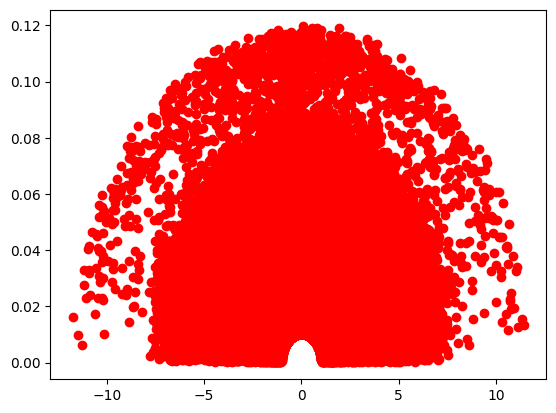

In [21]:
b = np.sqrt(z**2 + y **2) / 100
# print(len(b))
plt.plot(x,b,'ro')
nR = 300
project_b = np.linspace(0,1,nR)
dR = project_b[1] - project_b[0]

surface_brightness = np.zeros(nR)
test = np.zeros(nR)
for ii , bb in enumerate(project_b):
    R = (ii ) / (nR - 1)
    pp  =  np.where((b >= bb) & (b < bb+dR))[0]
    test[ii] = len(pp)
    if ii == 0 :
        surface_brightness[ii] = len(pp) / (np.pi*(0.5*dR)**2)
    elif ii == nR-1 :
        surface_brightness[ii] = len(pp) / (np.pi*(2*R+0.5*dR)*0.5*dR)
    else :
        surface_brightness[ii] = len(pp) / (2*np.pi*R*dR)
        

(0.0, 15.0)

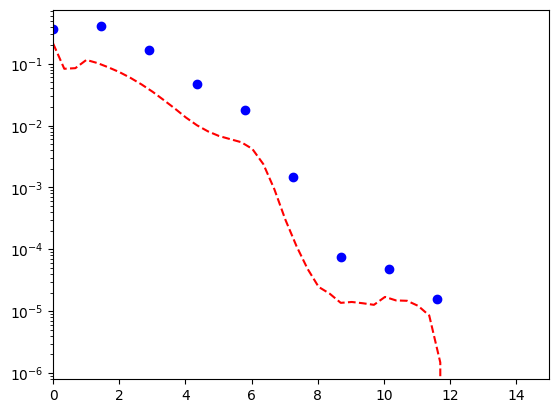

In [22]:
plt.plot(project_b*100,surface_brightness/sum(surface_brightness),'r--')
plt.plot(rt_radius_LT, rt_sb_t_LT/sum(rt_sb_t_LT) ,'bo')
plt.yscale('log')
plt.xlim(0,15)

In [22]:
(rt_radius_LT[1] - rt_radius_LT[0]) / 100

np.float64(0.014492754000000002)

(0.0, 15.0)

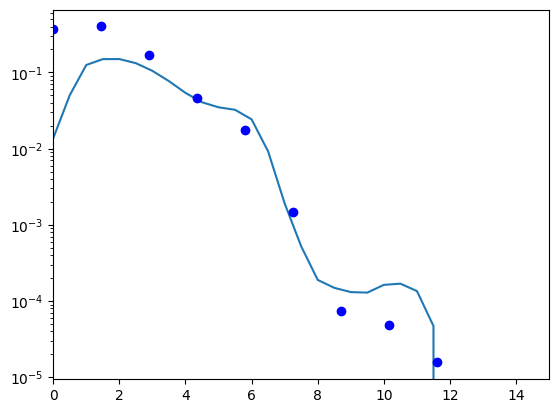

In [23]:
plt.plot(project_b*100 , test/sum(test))
plt.plot(rt_radius_LT, rt_sb_t_LT/sum(rt_sb_t_LT),'bo')
plt.yscale('log')
plt.xlim(0,15)

In [24]:
project_b

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

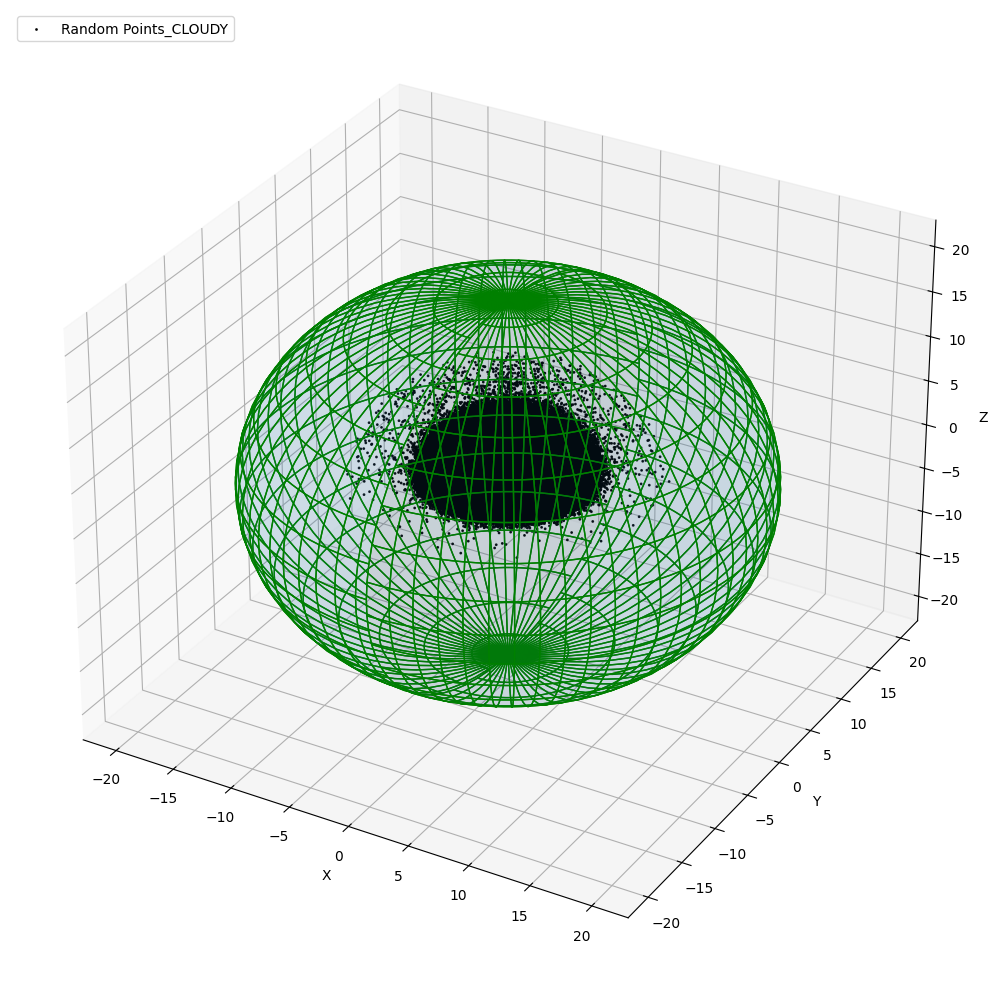

In [23]:
from mpl_toolkits.mplot3d import Axes3D

x_array = np.array(x)
y_array = np.array(y)
z_array = np.array(z)


theta= np.linspace(-np.pi/2, np.pi/2, 70)  
phi = np.linspace(0, 2 * np.pi, 70)  
theta, phi = np.meshgrid(theta,phi)

def x_y_z(radius_max,theta,phi):
    x_s = radius_max * np.sin(theta) * np.cos(phi)
    y_s = radius_max* np.sin(theta) * np.sin(phi)
    z_s = radius_max* np.cos(theta)
    return(x_s,y_s,z_s)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_array, y_array, z_array, c='k', marker='o', s=1,alpha=0.9, label="Random Points_CLOUDY")


x1,y1,z1 = x_y_z(20,phi,theta)
ax.plot_surface(x1, y1, z1, edgecolor='g', alpha=0.1)
# x1,y1,z1 = x_y_z(2,phi,theta)
# ax.plot_surface(x1, y1, z1, edgecolor='r', alpha=0.5)

# 축 설정
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend(loc='upper left')
fig.tight_layout()


In [ ]:
# # nR = 70

# set_R = np.arange(1,71,1)
# radius_sb =np.zeros(nR)
# sb = np.zeros(nR)
# for ii ,RR  in enumerate(set_R):
#     R = (RR - 1)/ (nR - 1)
#     if RR == 1:
#         radius_sb[ii] = R
#         sb_r = 
        